In [9]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 26/11/2021

    Code description :
    __________________
    Check that observations y are the same between the different observations models.
    Then compare the reconstructions to check they work the same.
    The object of interest is in 1D.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from functions import corr_circ
from graphics import show_rec1D

In [14]:
"Parameters"
N = 256 # vector size
K = 6 # sparsity
Q = 80 # Number of cores
M = 60 # Number of observations y

"Define the sparse object"
f = np.zeros(N)
f[np.random.permutation(np.arange(N))[:K]] = (-1)**(np.arange(K))

" From analytical developments, beware of the np.conj!!"
pos_cores = np.random.permutation(np.arange(N))[:Q] # random cores locations (/!\ Indices)
# pos_cores = np.round(np.arange(Q)*(N-1)/(Q-1)).astype(int) # regularly spaced cores locations
a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core
a_ij_outer = np.zeros((Q,Q,M), dtype=complex)
for m in range(M):
    a_ij_outer[:,:,m] = np.outer(a_ij[m], a_ij[m].conj())

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om = np.subtract.outer(pos_cores, pos_cores).astype(int)

"Compute the multiplicity of each frequency"
multiplicities = ind_multiplicity_1D(Om)

In [15]:
"ROP model"
div = 100
A_op = lambda Xin: np.real(A(S_Om_1D(T(Xin), Om), a_ij, diagless=False))
At_op = lambda Xin: np.real(T_star(S_Om_star_1D(A_star(Xin, a_ij_outer, diagless=False), Om, f.shape ) ))
# At_op = lambda Xin: np.real(T_star(S_Om_star_1D(A_star2(Xin, a_ij, diagless=False), Om, f.shape ) ))/div
nu_rop1 = eval_nu(np.random.randn(N), A_op, At_op, nb_iter=50)*1.01
adjoint_test(A=A_op,A_star=At_op,A_shape=[[N],[M]])
y1 = A_op(f)
adjoint1 = At_op(y1)

"Circulant matrix completion model"
beta = np.zeros((M,N), dtype=complex)
beta[:, pos_cores] = a_ij
beta2 = corr_circ(np.conj(beta)) # autocorrelations of beta

g = lambda x: np.real(beta2@T(x))/np.sqrt(M) # Note: it should be the conj of beta but same as it's random
gt = lambda x: np.real(T_star(beta2.conj().T@x))/np.sqrt(M)
nu_rop2 = eval_nu(np.random.randn(N), g, gt, nb_iter=50)*1.01
adjoint_test(A=g,A_star=gt,A_shape=[[N],[M]])
y2 = g(f) # The M real observations
adjoint2 = gt(y2)

assert np.sum(np.abs(nu_rop1-nu_rop2))<1e-8, "The nu are different..."
assert np.sum(np.abs(y1-y2))<1e-8, "The observations are different..."
assert np.sum(np.abs(adjoint1-adjoint2))<1e-8, "The adjoints are different..."

A and At are adjoint!
A and At are adjoint!


In [16]:
solver = solvers.forward_backward(step=1/(2*nu_rop1) )

maxit=300
SNR_target = 70
epsilon = np.linalg.norm(f)*10**(-SNR_target/20)
bigit = 10

Solution found after 300 iterations:
    objective function f(sol) = 6.519041e+00
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 1.042771e-02
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 3.420792e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.592826e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.903912e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.811462e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.922650e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.079341e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.950400e-03
    stopping criterion

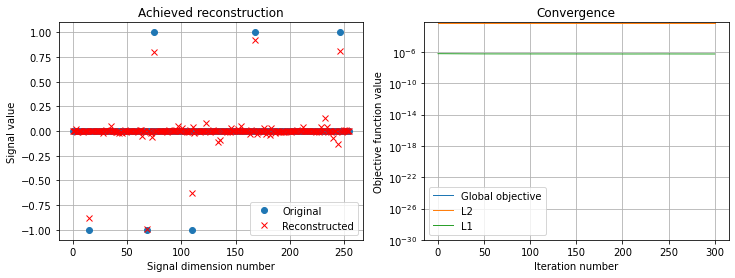

SNR: 12.57 dB


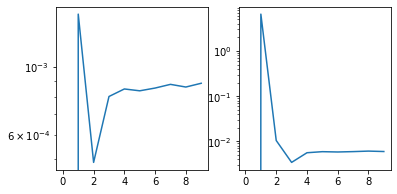

In [17]:
f2 = functions.norm_l2(y=y1, A=A_op, At=At_op, nu=nu_rop1, tight=False)

lamb1 = 1
f_hat1 = np.zeros(f.shape)
lambs1 = np.zeros(bigit)
objectives1 = np.zeros(bigit)
i=1
while (i<bigit): # and snr(f, f_hat)<40):
    x0 = f_hat1
    f1 = functions.norm_l1(lambda_=lamb1)
    ret1 = solvers.solve([f1, f2], x0, solver, rtol=1e-8, maxit=maxit) #, verbosity='NONE')
    f_hat1 = ret1['sol']
    lamb1 *= epsilon/np.linalg.norm(A_op(ret1['sol'])-y2)
    lambs1[i] = lamb1
    objectives1[i] = np.sum(np.array(ret1['objective'])[-1,:])
    i+=1

show_rec1D(f, ret1['sol'], ret1['objective'], labels=['L2', 'L1'], linewidth=1.0 )

plt.figure(figsize=(6,3))
plt.subplot(121)
plt.plot(lambs1, linewidth=1.5)
plt.gca().set_yscale('log')
plt.subplot(122)
plt.plot(objectives1, linewidth=1.5)
plt.gca().set_yscale('log')
plt.show()

Solution found after 300 iterations:
    objective function f(sol) = 6.519041e+00
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 1.042771e-02
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 3.420792e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.592814e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.903911e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.811321e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.922587e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.080343e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 5.950474e-03
    stopping criterion

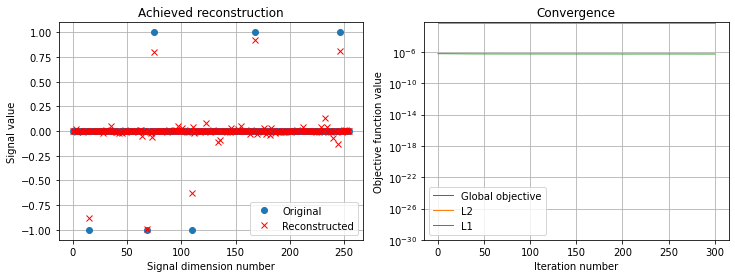

SNR: 12.57 dB


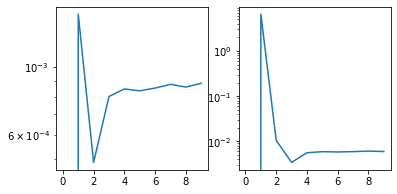

In [18]:
f2 = functions.norm_l2(y=y2, A=g, At=gt, nu=nu_rop2, tight=False)

f_hat2 = np.zeros(f.shape)
lambs2 = np.zeros(bigit)
objectives2 = np.zeros(bigit)
lamb2 = 1
i=1
while (i<bigit): # and snr(f, f_hat)<40):
    x0 = f_hat2
    f1 = functions.norm_l1(lambda_=lamb2)
    ret2 = solvers.solve([f1, f2], x0, solver, rtol=1e-9, maxit=maxit) #, verbosity='NONE')
    f_hat2 = ret2['sol']
    lamb2 *= epsilon/np.linalg.norm(g(ret2['sol'])-y2)
    lambs2[i] = lamb2
    objectives2[i] = np.sum(np.array(ret2['objective'])[-1,:])
    i+=1

show_rec1D(f, ret2['sol'], ret2['objective'], labels=['L2', 'L1'], linewidth=1.0 )

plt.figure(figsize=(6,3))
plt.subplot(121)
plt.plot(lambs2, linewidth=1.5)
plt.gca().set_yscale('log')
plt.subplot(122)
plt.plot(objectives2, linewidth=1.5)
plt.gca().set_yscale('log')
plt.show()

You should observe the iterations are exactly the same between the two models. Let us now analyse the computation time with SPGL1

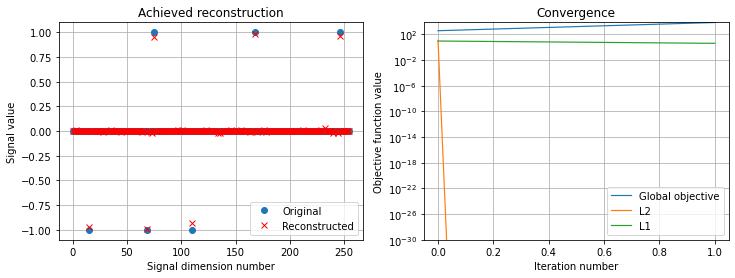

SNR: 26.02 dB


In [19]:
SNR_target = 100
opt_tol = np.linalg.norm(f)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol)

A_ROP = ROP_model(Om, a_ij, N)
A_ROP_r = Op2Real(A_ROP)
y_ROP_r = A_ROP_r@f
recovery = bpalg(A_ROP_r, y_ROP_r)
x_ROP = recovery[0]
xnorm1 = recovery[3]["xnorm1"]
rnorm2 = recovery[3]["rnorm2"]
show_rec1D(f, x_ROP, [rnorm2, xnorm1], labels=['L2', 'L1'], linewidth=1.2 )

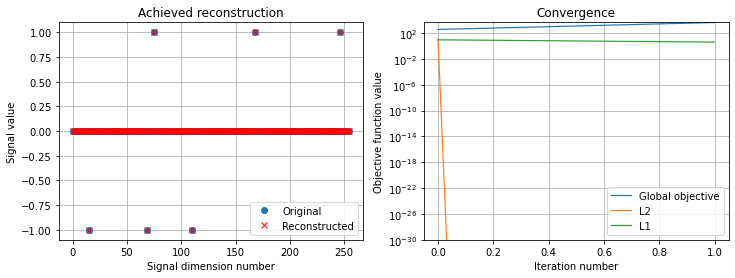

SNR: 102.79 dB


In [20]:
A_corr = Autocorr_model(beta2, wt=None)
A_corr_r = Op2Real(A_corr)
y_corr_r = A_corr_r@f
recovery = bpalg(A_corr_r, y_corr_r)
x_corr = recovery[0]
xnorm1 = recovery[3]["xnorm1"]
rnorm2 = recovery[3]["rnorm2"]
show_rec1D(f, x_corr, [rnorm2, xnorm1], labels=['L2', 'L1'], linewidth=1.2 )

The difference in computation time is related to the complexities of the two models:
- ROP is in $\mathcal{O}(MQ^2+N \log(N))$.
- Autocorrelation is in $\mathcal{O}(MN+N \log(N))$

The difference in reconstruction results is due to internal iterations in SPGL1.